# Forecasting con NNets tradicionales - SK-Learn

Vamos a utilizar modelos de redes neuronales para realizar tareas de pronóstico.

Los datos que vamos a analizar son los correspondientes al número de pasajeros aéreos mensuales. Van desde enero de 1949 hasta diciembre de 1960.

In [1]:
import numpy as np
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. Entendimiento de los datos

Cargamos los datos para entenderlos

In [3]:
df = pd.read_csv('01-02-AirPassengers.csv', sep=',', na_values=".")
print(df.shape)
df.head(5)

(144, 2)


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Vamos a modificar el nombre de las variables ("#Passengers" no nos permite acceder fácilmente a esa columna del dataframe).

In [4]:
df.columns = ['Mes', 'Pasajeros']

In [5]:
df.shape[0]

144

Tenemos 144 datos, correspondientes a los números de pasajeros mensuales en los últimos 12 años. Visualicemos los datos para buscar patrones.

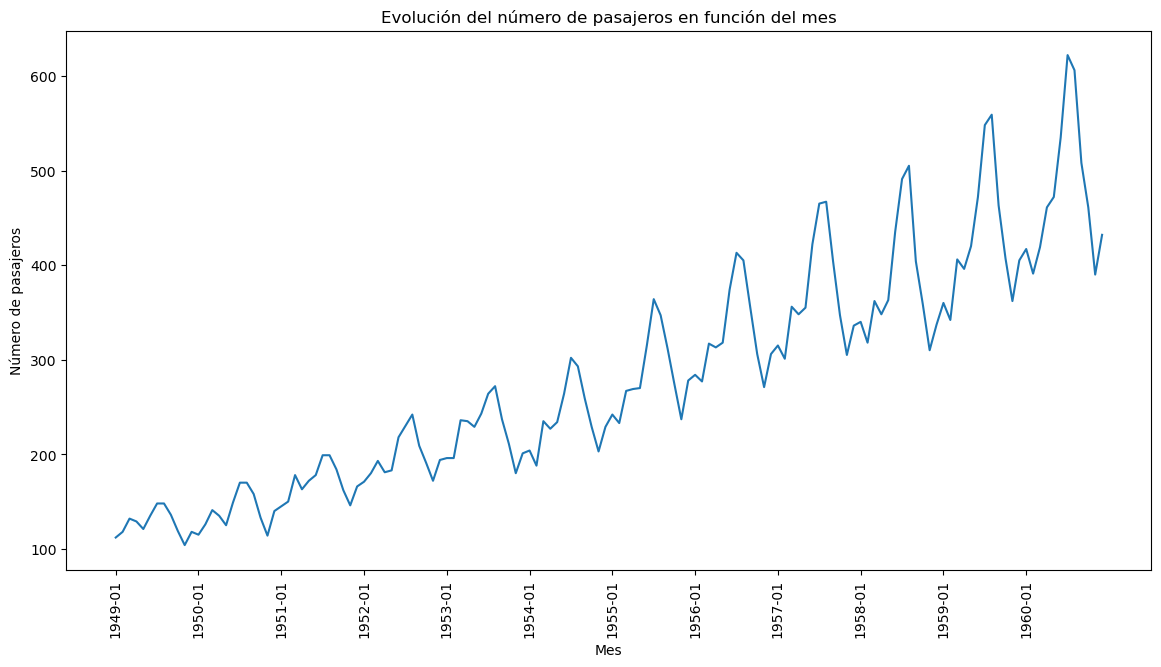

In [6]:
plt.figure(figsize=(14,7))
ax = plt.gca() # get current axis
plt.plot(df.Mes, df.Pasajeros)
plt.xlabel('Mes')
plt.ylabel('Número de pasajeros')
plt.title('Evolución del número de pasajeros en función del mes')
plt.xticks(np.arange(0,144,12), rotation=90)
plt.show()

Nos salta a la vista la estacionalidad de los datos y la tendencia creciente.

## 2. Preparación de los datos

Tenemos unos datos representados por una serie de tiempo univariada.

Al utilizar un modelo de redes neuronales con capas densas feed-forward para realizar pronósticos sobre series temporales univariadas, necesitamos configurar sus capas de entrada y de salida con respecto a lo que se espera del modelo. Hay diferentes aproximaciones posibles a considerar, con respecto al número de modelos que se van a desarrollar, a si se quiere un modelo con varios pronósticos al mismo tiempo o no, y a si se quieren tener en cuenta recursivamente o no las predicciones de modelos anteriores.

El número de neuronas de la capa de entrada debe establecerse con respecto a la ventana temporal de periodos contiguos que nos permitirán realizar el pronóstico. 

En el enfoque que vamos a adoptar, los inputs de la red neuronal van a representar los valores de la variable a pronosticar un cierto número de periodos atrás en el tiempo. 
Por ejemplo, con 6 neuronas, podemos tener en cuenta la información de 6 periodos contiguos (en este caso los 6 meses anteriores), uno por cada neurona.
Esto tiene como implicación que tenemos que **transformar los datos univariados** en particiones con tantos periodos contiguos como neuronas de entrada.
Otro enfoque podría ser considerar una mezcla de unos cuantos periodos contiguos anteriores con otros periodos separados. 
Por ejemplo, podríamos tener 2 neuronas para considerar los datos de los 2 meses anteriores, junto con los de 6, 12, 18 y 24 meses atrás.


Definimos también que vamos a pronosticar un solo periodo en el futuro, por lo que solo necesitaremos una neurona de salida. Se trata de un modelo de redes neuronales tradicional que se puede implementar con un estimador **MLPRegressor** del paquete **scikit-learn**. 

Como con el caso de las entradas, podríamos definir varios periodos futuros de salida, pero para eso ya tendríamos que utilizar **PyTorch**, u otro framework mas flexible, para poder especificar la topología particular que difiere de la de una red neuronal tradicional al tener múltiples neuronas en la capa de salida.

La siguiente función (tomada de https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/) nos permite obtener particionamientos de periodos contiguos en la serie de datos.

In [7]:
def split_sequence(sequence, n_steps):
    """
    Particiona una secuencia de datos en instancias compuestas por 
    - una secuencia contigua de predictores (del largo especificado)
    - el correspondiente siguiente valor que será tratado como variable objetivo en un modelo predictivo
    
    :sequence: 
        la serie de tiempo de origen
    :n_steps: 
        largo de la secuencia de predicción
    """
    X, y = list(), list() # se crean listas vacías donde agregaremos los valores de las variables predictivas (X)
                          # y de la variable objetivo (y)
        
    for i in range(len(sequence)): # recorremos la serie de tiempo posición por posición
        # Se obtiene el índice del final de la secuencia de datos con los valores de las variables predictivas (X)
        end_ix = i + n_steps 
        # condición de salida: no alcanzamos a obtener los datos de "X" y "y"
        if end_ix > len(sequence)-1: 
            break
        # creamos los datos de la instancia del periodo actual, los periodos del "X" y el periodo a predicir "y"
        # y los agregamos a las listas correspondientes
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y) # retornamos una tupla con los datos de la instancia

Por ejemplo, considerando los 6 meses anteriores para predecir el 7o, un dataset de 12 meses va a producir 6 instancias para el dataset de entrenamiento, donde tendremos como entradas los meses de enero a junio para predecir julio, los meses de febrero a julio para predecir agosto, y así sucesivamente.

In [8]:
df.iloc[0:12, 0]

0     1949-01
1     1949-02
2     1949-03
3     1949-04
4     1949-05
5     1949-06
6     1949-07
7     1949-08
8     1949-09
9     1949-10
10    1949-11
11    1949-12
Name: Mes, dtype: object

In [10]:
X, y = split_sequence(df.iloc[0:12, 0], 6)
for i in range(len(X)):
    print(X[i], y[i])

['1949-01' '1949-02' '1949-03' '1949-04' '1949-05' '1949-06'] 1949-07
['1949-02' '1949-03' '1949-04' '1949-05' '1949-06' '1949-07'] 1949-08
['1949-03' '1949-04' '1949-05' '1949-06' '1949-07' '1949-08'] 1949-09
['1949-04' '1949-05' '1949-06' '1949-07' '1949-08' '1949-09'] 1949-10
['1949-05' '1949-06' '1949-07' '1949-08' '1949-09' '1949-10'] 1949-11
['1949-06' '1949-07' '1949-08' '1949-09' '1949-10' '1949-11'] 1949-12


Creamos ahora nuestro dataset completo, sobre los datos del número de pasajeros. El numero de pasos a considerar lo vamos a establecer en 12, ya que se trata de datos anuales, y podemos encontrar evidencias visuales de ciclos de 12 datos en la exploración visual.

X va a contener los valores de la varible número de pasajeros de los 12 meses anteriores al valor contenido por y.
Adicionalmente, necesitamos tener saber el mes correspondiente al Y predicho.

In [9]:
pasos = 12

In [10]:
X, y = split_sequence(df.iloc[:, 1], pasos)

In [11]:
meses_pronosticados = df.iloc[pasos:,0]
meses_pronosticados

12     1950-01
13     1950-02
14     1950-03
15     1950-04
16     1950-05
        ...   
139    1960-08
140    1960-09
141    1960-10
142    1960-11
143    1960-12
Name: Mes, Length: 132, dtype: object

In [14]:
for i in range(len(X)):
    print(X[i], y[i])

[112 118 132 129 121 135 148 148 136 119 104 118] 115
[118 132 129 121 135 148 148 136 119 104 118 115] 126
[132 129 121 135 148 148 136 119 104 118 115 126] 141
[129 121 135 148 148 136 119 104 118 115 126 141] 135
[121 135 148 148 136 119 104 118 115 126 141 135] 125
[135 148 148 136 119 104 118 115 126 141 135 125] 149
[148 148 136 119 104 118 115 126 141 135 125 149] 170
[148 136 119 104 118 115 126 141 135 125 149 170] 170
[136 119 104 118 115 126 141 135 125 149 170 170] 158
[119 104 118 115 126 141 135 125 149 170 170 158] 133
[104 118 115 126 141 135 125 149 170 170 158 133] 114
[118 115 126 141 135 125 149 170 170 158 133 114] 140
[115 126 141 135 125 149 170 170 158 133 114 140] 145
[126 141 135 125 149 170 170 158 133 114 140 145] 150
[141 135 125 149 170 170 158 133 114 140 145 150] 178
[135 125 149 170 170 158 133 114 140 145 150 178] 163
[125 149 170 170 158 133 114 140 145 150 178 163] 172
[149 170 170 158 133 114 140 145 150 178 163 172] 178
[170 170 158 133 114 140 145

## 3. Modelamiento y evaluación

Vamos a llevar a cabo diferentes evaluaciones del modelo.

### 3.1 Estimación de un paso, entrenando con un subconjunto fijo de datos

Ahora que ya tenemos los datos en la presentación correcta, vamos a separarlos en dos particiones, una para entrenamiento y otra para evaluación.

Al tratarse de datos temporales, no tiene sentido particionar los datos de manera aleatoria, pues el orden de las secuencias de datos es importante. Vamos entonces a considerar una porción de los datos inicial, llamada *in-sample* para entrenar los modelos, seguida de la porción *out-of-sample*, que se utilizará para evaluar la capacidad predictiva.

La idea con este primer modelo es ponerse en la situación de negocio en la que **cada paso de tiempo se necesita predecir lo que va a pasar el paso de tiempo siguiente**, por lo que solo se necesita estimar un único valor futuro, a partir de una ventana predictiva histórica en la que todos los datos son reales y conocidos.

Tenemos 132 instancias, vamos a dejar los últimos 12 meses para evaluación, entrenando sobre los primeros 10 años (120 meses).

In [12]:
X.shape

(132, 12)

In [13]:
periodos_train =120
periodos_test = X.shape[0]-periodos_train

In [14]:
periodos_test

12

In [15]:
X_train = X[:periodos_train]
X_test = X[periodos_train:]
y_train = y[:periodos_train]
y_test = y[periodos_train:]
meses_train = meses_pronosticados[:periodos_train]
meses_test = meses_pronosticados[periodos_train:]
print("X_train: {}, y_train: {}\nX_test: {}, y_test: {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train: (120, 12), y_train: (120,)
X_test: (12, 12), y_test: (12,)


In [16]:
X_test

array([[360, 342, 406, 396, 420, 472, 548, 559, 463, 407, 362, 405],
       [342, 406, 396, 420, 472, 548, 559, 463, 407, 362, 405, 417],
       [406, 396, 420, 472, 548, 559, 463, 407, 362, 405, 417, 391],
       [396, 420, 472, 548, 559, 463, 407, 362, 405, 417, 391, 419],
       [420, 472, 548, 559, 463, 407, 362, 405, 417, 391, 419, 461],
       [472, 548, 559, 463, 407, 362, 405, 417, 391, 419, 461, 472],
       [548, 559, 463, 407, 362, 405, 417, 391, 419, 461, 472, 535],
       [559, 463, 407, 362, 405, 417, 391, 419, 461, 472, 535, 622],
       [463, 407, 362, 405, 417, 391, 419, 461, 472, 535, 622, 606],
       [407, 362, 405, 417, 391, 419, 461, 472, 535, 622, 606, 508],
       [362, 405, 417, 391, 419, 461, 472, 535, 622, 606, 508, 461],
       [405, 417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390]],
      dtype=int64)

In [23]:
meses_train

12     1950-01
13     1950-02
14     1950-03
15     1950-04
16     1950-05
        ...   
127    1959-08
128    1959-09
129    1959-10
130    1959-11
131    1959-12
Name: Mes, Length: 120, dtype: object

Entrenamos un modelo MLP regressor con los 120 meses.

In [17]:
np.random.seed(1234)
mlp = MLPRegressor(hidden_layer_sizes=(10,10,10), max_iter=500)
mlp.fit(X_train,y_train)


MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=500)

El modelo no se va a reentrenar con los datos del test set.

In [18]:
y_pred = mlp.predict(X_test)
print("RMSE:", sqrt(mean_squared_error(y_test, y_pred)), ", MAE:", mean_absolute_error(y_test, y_pred), ", R2:", r2_score(y_test, y_pred), "\n")

RMSE: 16.646911186419068 , MAE: 14.662016168909105 , R2: 0.9499736363083784 



In [19]:
y_pred

array([405.3286437 , 410.69065059, 444.58854674, 451.81995236,
       458.62932856, 523.37503406, 617.28834238, 619.92856425,
       518.86281294, 435.45174385, 417.50446503, 434.26219939])

Visualicemos los datos

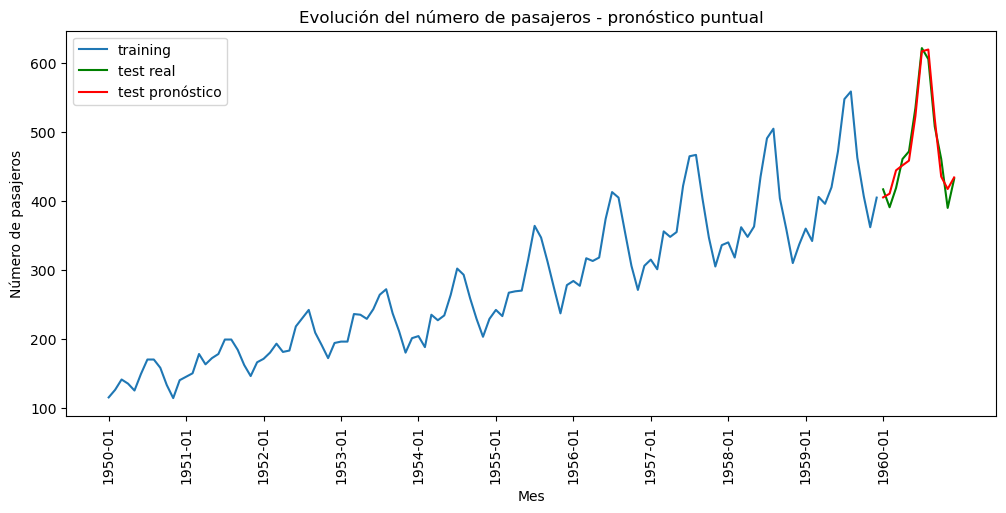

In [20]:
plt.figure(figsize=(12,5))
ax = plt.gca() # get current axis
plt.plot(meses_train, y_train, label="training")
plt.plot(meses_test, y_test, c="g", label="test real")
plt.plot(meses_test, y_pred, c="r", label="test pronóstico")
plt.xlabel('Mes')
plt.ylabel('Número de pasajeros')
plt.title('Evolución del número de pasajeros - pronóstico puntual')
plt.legend()
plt.xticks(np.arange(0,132,12), rotation=90)
plt.show()

### 3.2 Estimación de un paso, entrenando con un subconjunto fijo de datos, con pronóstico auto regresivo acumulado

En el punto anterior, se hacía una predicción puntual de un único valor futuro.
Muchas veces se quiere tener una predicción de más de un valor futuro. 

La idea con este segundo caso es ponerse en la situación de negocio en la que en cada paso de tiempo **se necesita predecir un periodo futuro compuesto por varios valores predichos**. 
Al tener un modelo con una única neurona de salida, es necesario realizar varias predicciones de manera iterativa auto-regresiva.
Para esto se considerarán valores anteriormente predichos dentro le ventana histórica para pronosticar los siguientes valores.
Para predecir t+1, se necesitan los valores reales conocidos t-11 hasta t; para predecir t+2, se necesitan los valores reales t-10 hasta t, además del valor predicho t+1; y así, sucesivamente.

<span style="color: red;">Puntos a desarrollar:</span>
- <span style="color: red;">Entrene un modelo sobre los primeros `periodos_train` datos de entrenamiento. Pueden utilizar la función `numpy.roll()`</span>
- <span style="color: red;">Itere sobre los 12 datos reales del test set  y para cada uno de ellos infiera el valor futuro predicho.</span>
- <span style="color: red;">Calcule el RMSE, MAE y R2 de la predicción.</span>
- <span style="color: red;">Grafique la serie de entrenamiento, la de test, y los valores predichos.</span>


In [21]:
X_train = X[:periodos_train]
y_train = y[:periodos_train]

Entrenamos el modelo una sola vez con los datos de entrenamiento.

In [22]:
np.random.seed(1234)
mlp = MLPRegressor(hidden_layer_sizes=(10,10,10), max_iter=500)
mlp.fit(X_train,y_train)

MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=500)

In [23]:
# Datos iniciales de entrenamiento 
X_train = X[:periodos_train]
y_train = y[:periodos_train]

In [24]:
X_train[-1]

array([337, 360, 342, 406, 396, 420, 472, 548, 559, 463, 407, 362],
      dtype=int64)

In [25]:
y_train[-1]

405

Vamos a predecir el primer valor futuro, considerando todos los datos de la última ventana conformada con datos conocidos, que corresponde a la primera ventana de test (que incluye el último \'y\' de training).
Creamos un ciclo para obtener los valores predichos uno a uno, modificando iterativamente la ventana histórica de predictores con los nuevos valores predichos.

In [26]:
X_pred = X[periodos_train].copy().astype(float)
X_pred

array([360., 342., 406., 396., 420., 472., 548., 559., 463., 407., 362.,
       405.])

In [34]:
X_pred = X[periodos_train].copy().astype(float)
y_preds = np.zeros(periodos_test)
for i in np.arange(0,periodos_test):
    # obtenemos la siguiente predicción
    y_preds[i] = mlp.predict(X_pred.reshape(1,pasos))
    # creamos la nueva ventana de predictores
    X_pred = np.roll(X_pred, -1)
    X_pred[pasos-1] = y_preds[i]
    #print(X_pred)
print(y_preds)

[405.3286437  410.56213793 444.70047986 455.7355327  460.27999275
 529.53090358 613.62873413 608.84215163 535.9088318  461.79403081
 404.51051191 443.78553071]


In [35]:
y_test = y[periodos_train:]
y_test

array([417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390, 432],
      dtype=int64)

In [36]:
print("RMSE:", sqrt(mean_squared_error(y_test, y_preds)), ", MAE:", mean_absolute_error(y_test, y_preds), 
      ", R2:", r2_score(y_test, y_preds), "\n")    

RMSE: 14.667252783179505 , MAE: 12.133322315351384 , R2: 0.9611644764021606 



In [37]:
y_train = y[:periodos_train]
y_test = y[periodos_train:]
meses_train = meses_pronosticados[:periodos_train]
meses_test = meses_pronosticados[periodos_train:]

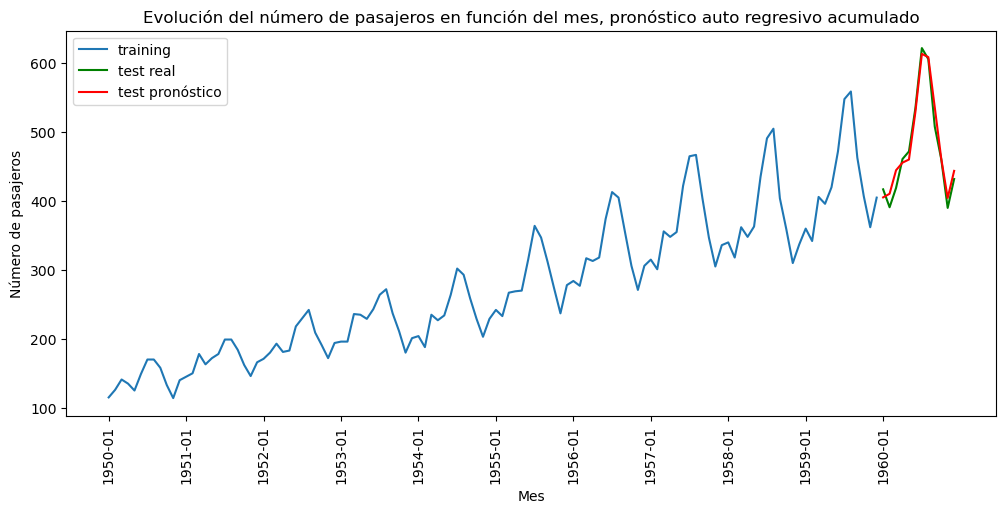

In [38]:
plt.figure(figsize=(12,5))
ax = plt.gca() # get current axis
plt.plot(meses_train, y_train, label="training")
plt.plot(meses_test, y_test, c="g", label="test real")
plt.plot(meses_test, y_preds, c="r", label="test pronóstico")
plt.xlabel('Mes')
plt.ylabel('Número de pasajeros')
plt.title('Evolución del número de pasajeros en función del mes, pronóstico auto regresivo acumulado')
plt.legend()
plt.xticks(np.arange(0,132,12), rotation=90)
plt.show()

### 3.3 Estimación de un paso, reentrenando con un subconjunto móvil de datos de largo fijo

Este caso es análogo al primero, **cada paso de tiempo se necesita predecir lo que va a pasar el paso de tiempo siguiente, con nuevo modelo sobre ventana móvil de datos**, la diferencia está en el hecho de que cada que se conozca un nuevo dato real, se va a utilizar un "nuevo" modelo que se  reentrena "desde cero" con una ventana móvil de tamaño fijo compuesta por los últimos 120 datos ya conocidos.

<span style="color: red;">Puntos a desarrollar:</span>
- <span style="color: red;">Cree un ciclo iterativo en el que avance sobre el periodo de test. Establezca una ventana móvil de los últimos 120 datos reales y con ella entrene un nuevo modelo, y prediga el siguiente valor.</span>
- <span style="color: red;">Calcule el RMSE, MAE y R2 de los 12 datos predichos.</span>
- <span style="color: red;">Grafique la serie de entrenamiento, la de test, y los valores predichos.</span>

In [39]:
y_preds = np.zeros(periodos_test)
for i in np.arange(0,periodos_test):
    X_train = X[i:i+periodos_train]
    y_train = y[i:i+periodos_train]
    X_test = X[i+periodos_train]
    y_test = y[i+periodos_train]
    np.random.seed(1234)
    mlp = MLPRegressor(hidden_layer_sizes=(10,10,10), max_iter=500)
    mlp.fit(X_train,y_train)  # se entrena un nuevo modelo con el nuevo dato real disponible 
    y_pred = mlp.predict(X_test.reshape(1,pasos))
    y_preds[i]=y_pred
    print("Entrenado con datos [", i, ", ", i+periodos_train, "].   ytest: ", y_test, ", y_pred: ", y_pred, sep="")


Entrenado con datos [0, 120].   ytest: 417, y_pred: [405.3286437]
Entrenado con datos [1, 121].   ytest: 391, y_pred: [411.08963182]
Entrenado con datos [2, 122].   ytest: 419, y_pred: [443.79729489]
Entrenado con datos [3, 123].   ytest: 461, y_pred: [449.4952866]
Entrenado con datos [4, 124].   ytest: 472, y_pred: [459.05571269]
Entrenado con datos [5, 125].   ytest: 535, y_pred: [524.65057804]
Entrenado con datos [6, 126].   ytest: 622, y_pred: [609.838837]
Entrenado con datos [7, 127].   ytest: 606, y_pred: [621.70946816]
Entrenado con datos [8, 128].   ytest: 508, y_pred: [519.42478862]
Entrenado con datos [9, 129].   ytest: 461, y_pred: [437.28248419]
Entrenado con datos [10, 130].   ytest: 390, y_pred: [419.17871129]
Entrenado con datos [11, 131].   ytest: 432, y_pred: [432.42455762]


In [40]:
y_preds

array([405.3286437 , 411.08963182, 443.79729489, 449.4952866 ,
       459.05571269, 524.65057804, 609.838837  , 621.70946816,
       519.42478862, 437.28248419, 419.17871129, 432.42455762])

In [41]:
y_test = y[periodos_train:]

In [42]:
print("RMSE:", sqrt(mean_squared_error(y_test, y_preds)), ", MAE:", mean_absolute_error(y_test, y_preds), 
      ", R2:", r2_score(y_test, y_preds), "\n")

RMSE: 17.08080868997915 , MAE: 15.331075847962978 , R2: 0.9473318009731572 



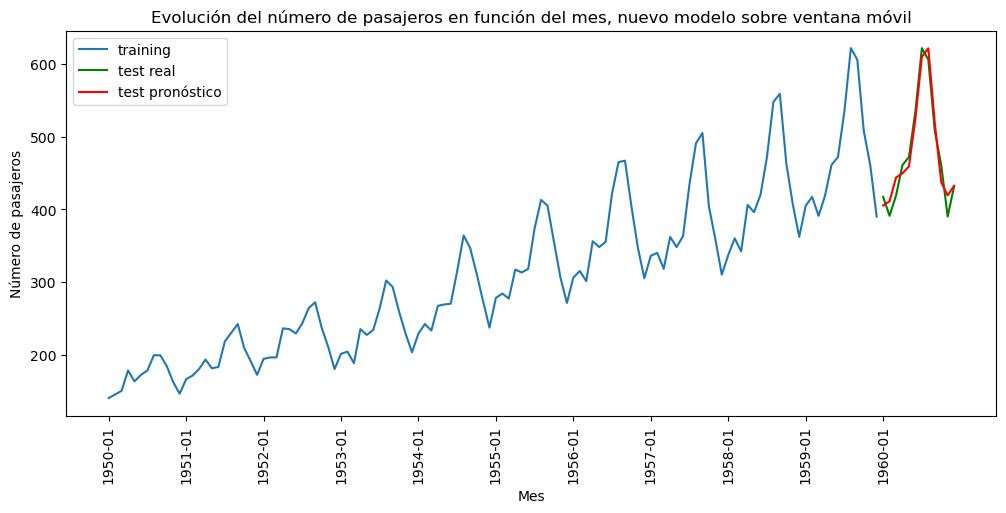

In [43]:
plt.figure(figsize=(12,5))
ax = plt.gca() # get current axis
plt.plot(meses_train, y_train, label="training")
plt.plot(meses_test, y_test, c="g", label="test real")
plt.plot(meses_test, y_preds, c="r", label="test pronóstico")
plt.xlabel('Mes')
plt.ylabel('Número de pasajeros')
plt.title('Evolución del número de pasajeros en función del mes, nuevo modelo sobre ventana móvil')
plt.legend()
plt.xticks(np.arange(0,132,12), rotation=90)
plt.show()

### 3.4 Estimación de un paso, reentrenando con un subconjunto móvil de datos de largo acumulado

Este caso es análogo al primero, **cada paso de tiempo se necesita predecir lo que va a pasar el paso de tiempo siguiente, con nuevo modelo sobre ventana móvil acumulada**, cada que se conozca un nuevo dato real, se va a utilizar un "nuevo" modelo que se reentrena "desde cero" con un conjunto de datos reales de entrenamiento cada vez más grande.
Esto puede eventualmente (aunque no necesariamente) tener efectos positivos en el performance del modelo.

In [44]:
y_preds = np.zeros(periodos_test)
for i in np.arange(0,periodos_test):
    X_train = X[:i+periodos_train] # siempre se empieza desde 0
    y_train = y[:i+periodos_train]
    X_test = X[i+periodos_train]
    y_test = y[i+periodos_train]
    np.random.seed(1234)
    mlp = MLPRegressor(hidden_layer_sizes=(10,10,10), max_iter=500)
    mlp.fit(X_train,y_train)
    y_pred = mlp.predict(X_test.reshape(1,pasos))
    y_preds[i]=y_pred
    print("Entrenadao con datos [", 0, ", ", i+periodos_train, "].   ytest: ", y_test, ", y_pred: ", y_pred, sep="")

Entrenadao con datos [0, 120].   ytest: 417, y_pred: [405.3286437]
Entrenadao con datos [0, 121].   ytest: 391, y_pred: [410.72825332]
Entrenadao con datos [0, 122].   ytest: 419, y_pred: [443.92471243]
Entrenadao con datos [0, 123].   ytest: 461, y_pred: [449.68272033]
Entrenadao con datos [0, 124].   ytest: 472, y_pred: [459.21976819]
Entrenadao con datos [0, 125].   ytest: 535, y_pred: [527.72225287]
Entrenadao con datos [0, 126].   ytest: 622, y_pred: [610.77687959]
Entrenadao con datos [0, 127].   ytest: 606, y_pred: [620.35585942]
Entrenadao con datos [0, 128].   ytest: 508, y_pred: [517.89465732]
Entrenadao con datos [0, 129].   ytest: 461, y_pred: [436.53374476]
Entrenadao con datos [0, 130].   ytest: 390, y_pred: [420.00508396]
Entrenadao con datos [0, 131].   ytest: 432, y_pred: [432.00173657]


In [45]:
y_test = y[periodos_train:]

In [46]:
print("RMSE:", sqrt(mean_squared_error(y_test, y_preds)), ", MAE:", mean_absolute_error(y_test, y_preds), 
      ", R2:", r2_score(y_test, y_preds), "\n")    

RMSE: 16.88170276979547 , MAE: 14.80385779772241 , R2: 0.948552519630942 



In [47]:
y_train = y[:periodos_train]
y_test = y[periodos_train:]
meses_train = meses_pronosticados[:periodos_train]
meses_test = meses_pronosticados[periodos_train:]

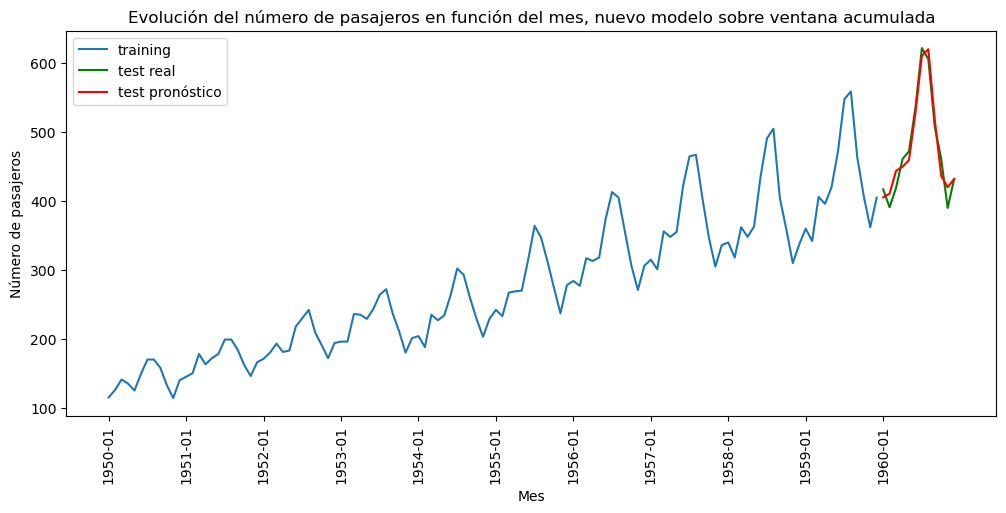

In [48]:
plt.figure(figsize=(12,5))
ax = plt.gca() # get current axis
plt.plot(meses_train, y_train, label="training")
plt.plot(meses_test, y_test, c="g", label="test real")
plt.plot(meses_test, y_preds, c="r", label="test pronóstico")
plt.xlabel('Mes')
plt.ylabel('Número de pasajeros')
plt.title('Evolución del número de pasajeros en función del mes, nuevo modelo sobre ventana acumulada')
plt.legend()
plt.xticks(np.arange(0,132,12), rotation=90)
plt.show()